In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, AveragePooling2D, AveragePooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm

import pandas as pd
import numpy as np
import random 

from importlib import reload  #reload(chart_builder)


In [1]:
generate_images = True
raw_data_dir = ''
acc_key = 'acc'
plot_examples = False # notebook file size will increase by 30 to 60MB if set to True; size is <1MB otherwise

if  'COLAB_GPU' in os.environ :
    print('Using Google Colab. Setting up environment')
    raw_data_dir = '/content/drive/My Drive/Colab Notebooks/' 
    !pip install mne==0.19.2
    !pip install pyedflib==0.1.15
    print('\n \n To load files from Google Drive, account validation is required.')
    # mount to drive -- files should be located in the /Colab Notebooks directory
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    
    # download project utilities and data reader 
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/ReadData
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/MLModels/utils

elif 'KAGGLE_URL_BASE' in os.environ:
    acc_key = 'accuracy'
    print('Using Kaggle kernel. Setting up environment')
    !pip install mne==0.19.2
    !pip install pyedflib==0.1.15
    !pip install chart_studio==1.0.0
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/Data/Raw
    raw_data_dir = 'Raw/'
    
    # download project utilities and data reader 
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/ReadData
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/MLModels/utils Utils


else:
    # assuming that a local run will be launched only from a github project; 
    # add the utils and ReadData directories to the temporary path
    if 'HOMEPATH' in os.environ:
        print('Using homepath ' + os.environ['HOMEPATH'])
    raw_data_dir = '../../Data/Raw/'
    
    from pathlib import Path
    import sys
    sys.path.append(os.path.realpath('..'))
    path = Path(os.getcwd())
    sys.path.append(str(path.parent.parent))


#################
# import project utilities and the raw data reader
# Kaggle environment does not accept 'utils' as a file, so it must be accessed seperately
import ReadData.RawDataReader as data_reader
if 'KAGGLE_URL_BASE' in os.environ:
    import Utils.ModelBuilder as model_builder
    import Utils.ChartBuilder as chart_builder
    
else:
    import utils.ModelBuilder as model_builder
    import utils.ChartBuilder as chart_builder


Using homepath \Users\marit


C:\Users\marit\Anaconda3\lib\site-packages\numba\decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


Loading BokehJS ...

In [4]:
%%capture
## ^^ do not display charts
import matplotlib.pyplot as plt 

class image_data_generator(object):

    def generate_spectrogram(self, data, save_chart=True, display_chart=False, file_name='test.png'):

        x = data
        NFFT = 256 # default value #24  # the length of the windowing segments
        Fs = 14 #   sampling frequency set to number of channels
        plt.ioff()
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False,
            labelleft=False) # labels along the bottom edge are off

        fig = plt.figure(figsize=(30, 40))
        ax = fig.add_subplot()

        Pxx, freqs, bins, im = ax.specgram(x, NFFT=NFFT, Fs=Fs)
        # The `specgram` method returns 4 objects. They are:
        # - Pxx: the periodogram
        # - freqs: the frequency vector
        # - bins: the centers of the time bins
        # - im: the matplotlib.image.AxesImage instance representing the data in the plot

        #plt.savefig(file_name)
        fig.savefig(file_name,bbox_inches='tight', transparent="True", pad_inches=0)
        if display_chart:
            plt.show()
            plt.close()

    #flatten data from all channels; group by time
    #X: 2-d array with channels as the second axis
    def flatten_data(self, X):
        x_adj = [] 
        for t in X:
            x_adj = np.append(x_adj, t)
        return x_adj

    def generate_image_files(self, batch, batch_labels, group_name):
        distinct_batch_labels = list(set(batch_labels))
        if not os.path.exists('gen_data/'+ group_name+'/'+distinct_batch_labels[0]):
            for dbl in distinct_batch_labels:
                os.makedirs('gen_data/'+group_name+'/'+ dbl)
        for i,sample in enumerate(batch):
            data_f = self.flatten_data(sample)
            label = batch_labels[i]
            self.generate_spectrogram(data_f, save_chart=True, #ImageDataGenerator expects files to be seperated by set/group and class
                                 file_name='gen_data/{}/{}/{}_{}.png'.format(group_name, label, group_name, i)) 



In [5]:
#reload(data_reader)
ignore_list = ['s12', 's14']  # List of patient files that should be skipped
resolution_hz = 250 # Hz resolution - number of frames per second; 250Hz is the selected value for the EEG dataset
time_window = resolution_hz * 20 # Seconds of data to include in one slice;

all_channels = ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4',
                'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']
excluded_channels = [ 'T3', 'T5', 'T6', 'O1', 'F3', 'Fp1', 'Fp2', 'P4']#F8'

chans=len(all_channels) - len(excluded_channels)

data = data_reader.get_raw_data(raw_data_dir, resolution_hz, ignore_list, 
                                excluded_channels, time_window)


Minimum duration:  740


'Shape of raw data for healthy controls: '

(14, 125001, 11)

'Shape of raw data for schizophrenic patients: '

(12, 125001, 11)

Selecting training  / testing / validation sets randomly from patient data
Splitting data into time windows to improve stability of results
(10, 125001, 11)
(250, 5000, 11)
Shape of X_train:  (450, 5000, 11)
Shape of X_validate:  (100, 5000, 11)
Shape of X_test:  (100, 5000, 11)
Removing outliers by channel
Selected indexes for control group: 
Training:  [4, 7, 13, 2, 9, 6, 3, 1, 0, 5]
Testing:  [11, 10]
Validation:  [8, 12]

Selected indexes for patient group: 
Training:  [9, 5, 1, 7, 10, 0, 3, 4]
Testing:  [2, 8]
Validation:  [11, 6]


In [15]:
# The first label should be the class that was originally set to 0 before one-hot encoding was applied;
# Healthy Controls in this case
def convert_one_hot_labels_to_strings(data_array, label_1, label_2):
    label_strings = []
    for label in data_array:
        if np.array_equal(label, [1., 0.]):
            string_label = label_1
        else:
            string_label = label_2
        label_strings.append(string_label)
    return label_strings

In [16]:

if generate_images:
    image_generator = image_data_generator()
    str_y_train = convert_one_hot_labels_to_strings(data['Y_train'],  'Healthy_Control', 'Sz_Patient')
    image_generator.generate_image_files(data['X_train'], str_y_train, 'train')
    str_y_validate = convert_one_hot_labels_to_strings(data['Y_validate'], 'Healthy_Control', 'Sz_Patient')
    image_generator.generate_image_files(data['X_validate'], str_y_validate, 'validate')
    str_y_test = convert_one_hot_labels_to_strings(data['Y_test'], 'Healthy_Control', 'Sz_Patient')
    image_generator.generate_image_files(data['X_test'], str_y_test, 'test')
    #generate_image_files(x_test[:2], 'gen_test')
    


C:\Users\marit\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



In [ ]:
if plot_examples:
    print ('TO DO: implement display of image files')
    #random_selection =  data_reader.get_random_participants(raw_data_dir, data, ignore_list, resolution_hz)
    #chart_builder.plot_random_participants(data, ignore_list, excluded_channels, all_channels, random_selection)


In [19]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint


# Construct a learning rate scheduler such that the lr is decreased when the loss remains unchanged after 4 epochs
# Adapted from https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.losses = []
        self.lr = []
        self.last_loss_improvement = None
        self.loss_unchanged_count = 0

    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        self.last_loss_improvement = 1.0
        self.loss_unchanged_count = 0

    def on_epoch_end(self, batch, logs={}):
        epoch_loss = logs.get('val_loss')
        # track if losses are being updated
        if (len(self.losses) > 1) and ((epoch_loss == self.losses[-1]) or (epoch_loss > self.last_loss_improvement)):
            self.loss_unchanged_count += 1
        else:
            self.loss_unchanged_count = 0
            self.last_loss_improvement = epoch_loss

        self.losses.append(epoch_loss)

    # Implement the lr_loss_scheduler within the class so that it can access loss_unchanged_count
    def on_epoch_begin(self, batch,
                       logs={}):
        if self.loss_unchanged_count > 3:
            self.loss_unchanged_count = 0  # reset
            current_lr = K.get_value(self.model.optimizer.lr)
            lr = current_lr - (current_lr / 2)  # decrement lr by 50% of current value
            K.set_value(self.model.optimizer.lr, lr)  # set for the model
            print('Updated learning rate to ', lr)
            # return K.get_value(self.model.optimizer.lr)

            
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true)))




In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math


from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, AveragePooling2D, AveragePooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.models import Sequential



# https://theailearner.com/2019/07/06/binary-classification/
sub_dir = 'gen_data' #'oxford_flower_dataset_subset'#
batch_size = 20
img_width, img_height = 150, 150

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(sub_dir + '/train/',target_size=(img_width,img_height),
                                                    batch_size=batch_size,class_mode='binary',interpolation='bilinear')
validation_generator = validation_datagen.flow_from_directory(sub_dir + '/validate/',target_size=(img_width,img_height),
                                                    batch_size=batch_size,class_mode='binary',interpolation='bilinear')
test_generator = test_datagen.flow_from_directory(sub_dir + '/test/',target_size=(img_width,img_height),
                                                  batch_size=batch_size,class_mode='binary',interpolation='bilinear')

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.models import Sequential

def image_cnn_model(img_width, img_height):
    model = Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_width,img_height,3)))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(32,(3,3),activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    #model.add(Conv2D(64,(3,3),activation='relu'))
    #model.add(MaxPool2D((2,2)))
    #model.add(Dropout(0.5))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.75))
    model.add(Flatten())
    model.add(Dense(36,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    
    return model


Found 450 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K

model = image_cnn_model(img_width, img_height)
model.summary()

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true)))
metrics = ['accuracy', rmse]

image_cnn_opt_adam = tf.keras.optimizers.Adam(lr=0.0007, 
                                beta_1=0.95,
                                beta_2=0.89,
                                epsilon=1e-07)

model.compile(loss='binary_crossentropy', optimizer=image_cnn_opt_adam, metrics=metrics)

filepath = 'img_cnn_weights.hdf5'

checkpoint = ModelCheckpoint(filepath, #monitor='val_acc', 
                             verbose=0, save_best_only=True, save_weights_only=True, mode='auto',period=1)

history = model.fit_generator(train_generator, steps_per_epoch=math.floor(train_generator.samples // batch_size), 
                                            epochs=100, validation_data=validation_generator,
                                            validation_steps=math.floor(validation_generator.samples // batch_size),  
                                                                        callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 34, 34, 64)        18496     
__________

Epoch 57/100
23/23 [==============================] - 69s 3s/step - loss: 0.3082 - acc: 0.9178 - rmse: 0.3036 - val_loss: 0.5639 - val_acc: 0.7300 - val_rmse: 0.4367
Epoch 58/100
23/23 [==============================] - 64s 3s/step - loss: 0.3191 - acc: 0.9200 - rmse: 0.3054 - val_loss: 0.5684 - val_acc: 0.7200 - val_rmse: 0.4359
Epoch 59/100
23/23 [==============================] - 65s 3s/step - loss: 0.2985 - acc: 0.9244 - rmse: 0.2983 - val_loss: 0.5366 - val_acc: 0.7500 - val_rmse: 0.4215
Epoch 60/100
23/23 [==============================] - 64s 3s/step - loss: 0.2894 - acc: 0.9400 - rmse: 0.2903 - val_loss: 0.5724 - val_acc: 0.7000 - val_rmse: 0.4413
Epoch 61/100
23/23 [==============================] - 64s 3s/step - loss: 0.2867 - acc: 0.9289 - rmse: 0.2872 - val_loss: 0.5418 - val_acc: 0.7300 - val_rmse: 0.4263
Epoch 62/100
23/23 [==============================] - 64s 3s/step - loss: 0.3074 - acc: 0.9133 - rmse: 0.2991 - val_loss: 0.5396 - val_acc: 0.7100 - val_rmse: 0.4257
Epoc

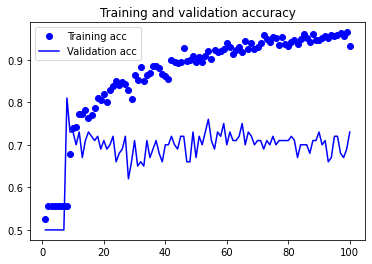

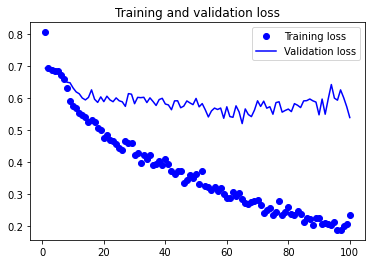

In [21]:
#https://github.com/wtfleming/jupyter-notebooks-public/blob/master/dogs-vs-cats/dogs-vs-cats-part-2.ipynb
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
plot_accuracy_and_loss(history)

In [22]:
#https://wtfleming.github.io/2019/05/12/keras-cats-vs-dogs-part-2/
    
test_generator = test_datagen.flow_from_directory(
    sub_dir + '/test/',
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='binary')

test_loss, test_acc, test_rmse = model.evaluate_generator(test_generator, steps=90)
print('Test accuracy: {0:.2f}%   | Test loss: {1:.5f} | Test RMSE: {2:.5f}'.format(test_acc * 100, test_loss, test_rmse))

Found 100 images belonging to 2 classes.
Test accuracy: 68.00%   | Test loss: 0.51177 | Test RMSE: 0.41339


In [118]:
train_generator.samples

450

In [46]:
!pip freeze

absl-py==0.9.0
affine==2.3.0
aiohttp==3.6.2
alabaster==0.7.12
albumentations==0.4.3
alembic==1.4.1
allennlp==0.9.0
altair==4.0.1
anaconda-client==1.7.2
anaconda-navigator==1.9.12
anaconda-project==0.8.3
annoy==1.16.3
appdirs==1.4.3
arrow==0.15.5
arviz==0.7.0
asn1crypto==1.3.0
astor==0.8.1
astroid==2.3.3
astropy==3.2.3
async-timeout==3.0.1
atomicwrites==1.3.0
attr==0.3.1
attrs==19.3.0
audioread==2.1.8
aws-requests-auth==0.4.2
Babel==2.8.0
backcall==0.1.0
backports.functools-lru-cache==1.6.1
backports.os==0.1.1
backports.shutil-get-terminal-size==1.0.0
backports.tempfile==1.0
backports.weakref==1.0.post1
Baker==1.3
basemap==1.2.0
bayesian-optimization==1.1.0
bayespy==0.5.19
bcolz==1.2.1
beautifulsoup4==4.8.2
biopython==1.76
bitarray==1.2.1
bkcharts==0.2
bleach==3.1.0
blis==0.4.1
bokeh==1.4.0
Boruta==0.3
boto==2.49.0
boto3==1.12.13
botocore==1.15.13
Bottleneck==1.3.2
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_helper
bqplot==0.12.4


In [47]:
from platform import python_version

print(python_version())

3.6.6
